In [1]:
from torch import nn
import torch

In [2]:
from torch.nn.utils.rnn import pad_sequence

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import os

In [6]:
from einops import rearrange

In [7]:
import random

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torchvision.transforms as T

In [10]:
from skimage.util import random_noise

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [12]:
import torchaudio

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
from sklearn import preprocessing

In [14]:
from sklearn.model_selection import train_test_split

# Defining Dataseat

In [15]:
class MusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, seq_len=10000, random_start=True, noise=True):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.padder = torch.zeros(96, seq_len)
        self.labels = labels
        self.noise = noise
        self.random_start = random_start
#         self.labels = []
#         for i in range(len(self.files)):
#             label = np.random.randint(0, 10, size=15)
#             label[label > 8] = 0
#             label[label >= 1] = 1
#             self.labels.append(label)
#         for i in range(len(self.files)):
#             label = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#             self.labels.append(label)
    def __len__(self):
        return len(self.files)

#     def __getitem__(self, index):
#         return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])
    def __getitem__(self, index):
        x = np.load(self.files[index])
        x = torch.from_numpy(x).float()
#         print(x.shape)
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than 3000, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        x = pad_sequence([x.T, self.padder.T], padding_value=-90, batch_first=True)[0].T
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1)

        if self.noise:
#             x = torch.tensor(random_noise(x, mode='gaussian', mean=0, var=0.05, clip=False)).float()
            x = torch.tensor(random_noise(x, mode='gaussian', mean=0, var=0.1, clip=False)).float()
#         input,label_ids,label
        item = {"input": x, "label_ids":[index], "labels": torch.tensor(self.labels[index])}
        return item
#         return x

In [16]:
from datasets import load_dataset

In [17]:
from datasets import disable_caching
disable_caching()

In [18]:
# good_files = []
# for i in range(1, 6):
#     new_files = [f"0{i}/{fname.replace('npy', '')}mp3" for fname in os.listdir(f"../../subset_moodtheme/0{i}")]
#     good_files.extend(new_files)

# test_files = [f"00/{fname.replace('npy', '')}mp3" for fname in os.listdir("../../subset_moodtheme/00")]
# print(good_files)
# print(test_files)

In [19]:
with open("goodfiles.txt", 'r') as f:
    all_files = f.readlines()
all_files = [g.strip().replace("npy", 'mp3') for g in all_files if len(g.strip()) > 0]

In [20]:
all_files[:3]

['01/846501.mp3', '34/1288334.mp3', '98/1082098.mp3']

In [21]:
good_files, test_files = train_test_split(all_files, test_size=0.2)

In [22]:
len(good_files), len(test_files)

(2200, 551)

In [23]:
def files_to_labels(files):
    col_names = ['TRACK_ID',
     'ARTIST_ID',
     'ALBUM_ID',
     'PATH',
     'DURATION',
     'TAGS',
     'TAGS2',
     'TAGS3',
     'TAGS4',
     'TAGS5',
     'TAGS6',
     'TAGS7',
     'TAGS8',
     'TAGS9']
    MOODPATH = "../../../Downloads/autotagging_moodtheme.tsv.txt"
    df = pd.read_csv(MOODPATH, sep='\t', names=col_names)
    df = df[df["PATH"].isin(files)]
    inds = {'fast': 0,
     'sexy': 1,
     'mellow': 2,
     'heavy': 3,
     'horror': 4,
     'travel': 5,
     'holiday': 6,
     'groovy': 7,
     'funny': 8,
     'retro': 9,
     'hopeful': 10,
     'powerful': 11,
     'cool': 12,
     'nature': 13,
     'game': 14}

    final_labels = []
    for i in range(len(df)):
        curr = np.zeros(len(inds))
        moods = list(df.iloc[i])[5:]
        for theme in moods:
            if type(theme) == str and "mood" in theme:
                check = theme.split("---")[-1]
                if check in inds:
                    curr[inds[check]] = 1
            else:
                pass

        final_labels.append(curr)
    return final_labels

In [24]:
train_labels = files_to_labels(good_files)

In [25]:
test_labels = files_to_labels(test_files)

In [26]:
train_labels[:2]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [27]:
# train_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in good_files]
# test_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in test_files]
train_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in good_files]
test_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in test_files]

In [28]:
train_np_files[:2], test_np_files[:2]

(['../../mtg-jamendo-dataset/all_data/05/108505.npy',
  '../../mtg-jamendo-dataset/all_data/65/1283765.npy'],
 ['../../mtg-jamendo-dataset/all_data/59/1355559.npy',
  '../../mtg-jamendo-dataset/all_data/39/1400039.npy'])

In [29]:
import time

In [30]:
# SEQ_LEN = 10000
SEQ_LEN = 3000
# SEQ_LEN = 5000

In [31]:
train_dataset = MusicDataset(train_np_files, train_labels, seq_len=SEQ_LEN, noise=True, random_start=True)
test_dataset = MusicDataset(test_np_files, test_labels, seq_len=SEQ_LEN, noise=False, random_start=True)

# MODEL TESTING
run dataset stuff first

In [32]:
len(train_dataset)

2200

In [33]:
inp = train_dataset[0]['input']
# inp = inp.unsqueeze(0)
inp.shape

torch.Size([1, 3000, 96])

### Structure we want

* downsample with CNN
* feed into transformer
* feed into linear layer
* profit

In [34]:
inp.shape

torch.Size([1, 3000, 96])

In [35]:
inp.unsqueeze(0)

tensor([[[[-15.7967, -12.0677, -14.6465,  ..., -31.5182, -37.4343, -58.1641],
          [-16.4617, -12.7095, -16.7593,  ..., -29.8667, -37.9322, -58.8569],
          [-21.6574, -16.9195, -14.8174,  ..., -29.6028, -39.2975, -55.4645],
          ...,
          [-19.4125, -19.0983, -19.1256,  ..., -42.5181, -47.1971, -66.7183],
          [ -6.8851,  -6.9258, -14.1845,  ..., -21.9073, -34.1376, -49.9932],
          [ -7.5797, -11.0690, -25.2738,  ..., -26.4352, -39.0534, -50.6404]]]])

In [36]:
start_data = inp.unsqueeze(0)

In [71]:
conv = nn.Conv2d(1, 1, kernel_size=13, stride=(8, 1),padding=2)
# cout = conv(inp)
cout = conv(start_data)
cout.shape

torch.Size([1, 1, 374, 88])

In [72]:
# reshape so its function of 16
# cout = cout[:,:,:320]
cout = cout[:,:,:,:]
cout.shape

torch.Size([1, 1, 374, 88])

In [73]:
# patch_size = 16

In [74]:
# # put into patches
# patched = rearrange(cout, 'b (h s1) (w s2) -> b (h w) (s1 s2)', s1=patch_size, s2=patch_size)
patched = cout
patched.shape

torch.Size([1, 1, 374, 88])

In [75]:
class Patcher(torch.nn.Module):
    def forward(self, x):
#         x = x[:,:,:960]
#         x = x[:,:,:,:960]
        x = x.squeeze(1)
#         return rearrange(x, 'b (h s1) (w s2) -> b (h w) (s1 s2)', s1=patch_size, s2=patch_size)
        return x

Copying from:  https://n8henrie.com/2021/08/writing-a-transformer-classifier-in-pytorch/

In [76]:
patched = Patcher()(cout)

In [77]:
patched.shape

torch.Size([1, 374, 88])

In [78]:
# encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8)
d_model = patched.shape[-1]
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

In [79]:
transed = transformer_encoder(patched)
transed.shape

torch.Size([1, 374, 88])

In [82]:
# layer_norm = nn.LayerNorm(256)
layer_norm = nn.LayerNorm(d_model)
layered = layer_norm(transed)
layered.shape

torch.Size([1, 374, 88])

In [83]:
class BertPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
#         self.activation = nn.Tanh()
        self.activation = nn.ReLU()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
#         first_token_tensor = hidden_states[:,0]
        first_token_tensor = hidden_states[:,0,:]
        pooled_output = self.dense(first_token_tensor)
#         pooled_output = self.activation(pooled_output)
        return pooled_output

In [85]:
# bp = BertPooler(256)
bp = BertPooler(d_model)
bp(layered).shape

torch.Size([1, 88])

In [86]:
lined = nn.Linear(d_model, 15)

In [87]:
drop = nn.Dropout(0.1)

In [88]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.flatten()

In [89]:
class Meaner(torch.nn.Module):
    def forward(self, x):
        return torch.mean(x, dim=1)

In [90]:
x = start_data
for layer in [torch.nn.BatchNorm2d(1),
    conv,
    Patcher(),
#     Flatten()
#     Patcher(),
    transformer_encoder,
#         Flatten()
#     layer_norm,
#     bp,
#         Flatten()
#     drop,]:
    Meaner(),
             ]:
    layer = layer.to("cpu")
    x = layer(x.to("cpu"))
    print(x)
    print(x.shape)

tensor([[[[ 0.6492,  0.9630,  0.7460,  ..., -0.6740, -1.1719, -2.9167],
          [ 0.5932,  0.9090,  0.5682,  ..., -0.5350, -1.2138, -2.9750],
          [ 0.1559,  0.5547,  0.7316,  ..., -0.5128, -1.3288, -2.6894],
          ...,
          [ 0.3449,  0.3713,  0.3690,  ..., -1.5998, -1.9936, -3.6366],
          [ 1.3992,  1.3958,  0.7849,  ...,  0.1349, -0.8945, -2.2290],
          [ 1.3408,  1.0471, -0.1485,  ..., -0.2462, -1.3082, -2.2834]]]],
       grad_fn=<NativeBatchNormBackward0>)
torch.Size([1, 1, 3000, 96])
tensor([[[[ 0.6589,  0.7890,  0.6997,  ..., -1.1008, -0.3079,  0.1119],
          [ 1.0076,  0.6742,  1.0657,  ..., -1.0542, -0.0285,  0.2337],
          [ 0.4240,  1.1219,  1.4148,  ..., -1.0332, -0.2384,  0.0793],
          ...,
          [ 0.3446,  0.5984,  0.2689,  ..., -1.1811, -0.1963, -0.1152],
          [ 0.5451,  1.1091,  1.3210,  ..., -0.8925,  0.0300,  0.0826],
          [-0.3545, -0.0976,  0.3215,  ..., -1.4201, -0.4917, -0.2920]]]],
       grad_fn=<ConvolutionB

In [91]:
x.shape

torch.Size([1, 88])

In [92]:
torch.mean(x, dim=1).shape

torch.Size([1])

In [93]:
mod = nn.Sequential(
    torch.nn.BatchNorm2d(1),
    conv,
    Patcher(),
#     Flatten()
#     Patcher(),
    transformer_encoder,
#         Flatten()
#     layer_norm,
#     bp,
#         Flatten()
#     drop,
#     lined
)

In [94]:
# mod(start_data).shape

In [95]:
model = mod

In [96]:
sum(p.numel() for p in model.parameters())

2365756

In [97]:
heads = [nn.Sequential(nn.Linear(96, 1), nn.Sigmoid()) for i in range(15)]
# heads = [nn.Sequential(nn.Linear(10688, 2), nn.Sigmoid()) for i in range(15)]
# heads = [nn.Sequential(nn.Linear(10240, 2), nn.Sigmoid()) for i in range(15)]

In [98]:
# heads[0](mod(start_data))

## Try Training

In [99]:
from torch.utils.data import DataLoader
# from transformers import AdamW
import torch.optim as optim
from tqdm import tqdm

In [102]:
# batch_size = 8
batch_size = 16

In [103]:
train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

test_dl = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [105]:
# conv = nn.Conv2d(1, 1, kernel_size=5, stride=(5, 1), padding=2)
# conv = nn.Conv2d(1, 1, kernel_size=5, stride=(3, 1), padding=2, padding_mode="replicate")
conv = nn.Conv2d(1, 1, kernel_size=13, stride=(8, 1), padding=2, padding_mode="replicate")
d_model = 88
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
# encoder_layer = nn.TransformerEncoderLayer(d_model=96, nhead=8, batch_first=True)
# encoder_layer = nn.TransformerEncoderLayer(d_model=96, nhead=2, batch_first=True)
# transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
# transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
# transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
layer_norm = nn.LayerNorm(d_model)

# layer_norm = nn.LayerNorm(96)
# bp = BertPooler(96)
# drop = nn.Dropout(0.1)

In [106]:
model = nn.Sequential(
    torch.nn.BatchNorm2d(1),
    conv,
    Patcher(),
    transformer_encoder,
    Meaner(),
#     layer_norm,
#     bp,
#     Flatten(),
#     drop,
)

In [107]:
# dim = 96
dim = d_model
# dim = 96 * 600
# heads = [nn.Sequential(nn.Linear(96, 96), nn.ReLU(), nn.Linear(96, 1), nn.Sigmoid()) for i in range(15)]
# heads = [nn.Sequential(nn.Linear(dim, 96), nn.ReLU(), nn.Linear(96, 1), nn.Sigmoid()) for i in range(15)]
# heads = [nn.Sequential(nn.Linear(dim, 96), nn.ReLU(), nn.Linear(96, 1), nn.Sigmoid()) for i in range(15)]
heads = [nn.Sequential(nn.Linear(dim, 1), nn.Sigmoid()) for i in range(15)]

In [108]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [109]:
# class_weights = torch.tensor([15]).to(device)

In [110]:
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.parameters(), lr=5e-3)
# optimizer = optim.AdamW(model.parameters(), lr=1e-2)
optimizer = optim.AdamW(model.parameters(), lr=1e-2)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
# criterion = nn.BCELoss(weight=class_weights)
# losses = [nn.CrossEntropyLoss() for i in range(15)]

In [111]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        per_head_outputs = [h(outputs) for h in heads]
        
        for i in range(15):
            cur_loss = criterion(per_head_outputs[i].squeeze(1), labels[:,i].float())
            total_loss += cur_loss
    return total_loss.item()

In [112]:
def get_mask(targs):
    mask = []
    for val in targs:
        m = int(val) == 1 or random.random() < 0.05
        mask.append(m)
#     if sum(mask) == 0:
# #         print("YIKES")
#         mask[0] = True
    return mask

In [113]:
torch.cuda.empty_cache()

In [114]:
model = model.to(device)
heads = [h.to(device) for h in heads]
model.train()
for h in heads:
    h.train()
    
train_losses = []
adjusted_train_losses = []
test_losses = []
for epoch in range(10):
# for epoch in range(5):
    total_loss = 0
#     for batch in train_loader:
    for batch_idx, data in tqdm(enumerate(train_dl), total=len(train_dl)):
        these_losses = []
        optimizer.zero_grad()
        inputs, labels = data['input'].to(device), data['labels'].to(device)
        outputs = model(inputs)
        per_head_outputs = [h(outputs) for h in heads]
        for i in range(15):
            preds = per_head_outputs[i].squeeze(1)
            targs = labels[:,i].float()
            mask = get_mask(targs)
            if sum(mask) == 0:
                continue
            cur_loss = criterion(preds[mask], targs[mask])
            these_losses.append(cur_loss)

        loss = sum(these_losses)
        loss.backward()
        optimizer.step()
        # for bookkeeping
        total_loss += loss.item()
#     total_loss.backward()
        
#     total_loss += loss.item()
#         break
    with torch.no_grad():
        train_total_loss = get_total_loss(model, train_dl)
        test_loss = get_total_loss(model, test_dl)
        adjusted = total_loss
        train_losses.append(train_total_loss)
        adjusted_train_losses.append(adjusted)
        test_losses.append(test_loss)
    #     print(f"Epoch: {epoch}; Loss: {adjusted}; Total Loss: {train_total_loss}; Test Loss: {test_loss}")
        print(f"Epoch: {epoch}; Loss: {adjusted}; Test Loss: {test_loss}")

model.eval()
for h in heads:
    h.eval()

100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:34<00:00,  3.98it/s]


Epoch: 0; Loss: 1254.0187096595764; Test Loss: 7204.8623046875


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:30<00:00,  4.48it/s]


Epoch: 1; Loss: 1186.4349222183228; Test Loss: 8147.1689453125


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:31<00:00,  4.44it/s]


Epoch: 2; Loss: 1218.3740229606628; Test Loss: 7834.25927734375


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:30<00:00,  4.47it/s]


Epoch: 3; Loss: 1194.2649641036987; Test Loss: 7159.6904296875


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:30<00:00,  4.46it/s]


Epoch: 4; Loss: 1194.5830688476562; Test Loss: 7248.38037109375


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:30<00:00,  4.46it/s]


Epoch: 5; Loss: 1184.574514389038; Test Loss: 7736.1748046875


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:31<00:00,  4.45it/s]


Epoch: 6; Loss: 1183.2410616874695; Test Loss: 7481.02734375


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:30<00:00,  4.53it/s]


Epoch: 7; Loss: 1189.1163921356201; Test Loss: 7179.53857421875


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:30<00:00,  4.52it/s]


Epoch: 8; Loss: 1192.6483507156372; Test Loss: 7185.61669921875


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:32<00:00,  4.22it/s]


Epoch: 9; Loss: 1198.585114479065; Test Loss: 7392.9287109375


In [115]:
# adjusted_train_losses = [l.item() for l in adjusted_train_losses]

In [116]:
len(train_losses), len(test_losses), len(adjusted_train_losses)

(10, 10, 10)

<AxesSubplot:>

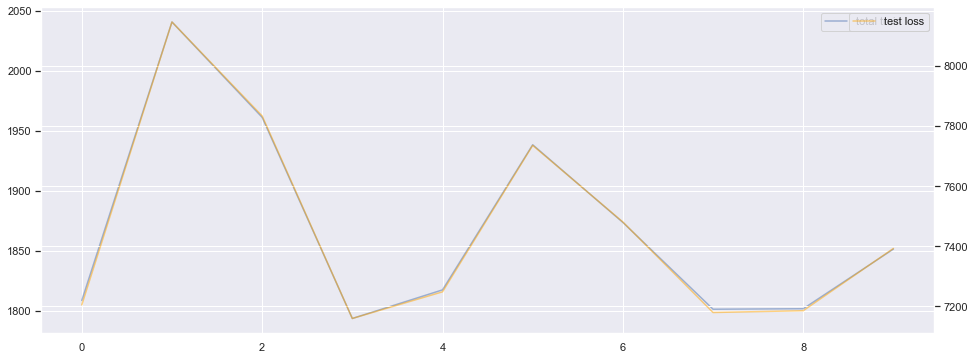

In [119]:
plt.figure(figsize=(16, 6))
ranger = list(range(len(train_losses)))
sns.lineplot(x=ranger, y=train_losses, label="total train loss", alpha=0.5)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
ax2 = plt.twinx()
sns.lineplot(x=ranger, y=test_losses, label="test loss", ax=ax2, color="orange", alpha=0.5)

In [120]:
model.eval()
for h in heads:
    h.eval()
# In[ ]:

res_per_head = {i:[] for i in range(15)}

with torch.no_grad():
#     a = model(dataset[2]['input'].to(device))
    total_correct = 0
    zero_correct = 0
    total_values = 0
    only_positives = [0, 0]
    for batch_idx, data in enumerate(test_dl):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        per_head_outputs = [h(outputs) for h in heads]
        found_not_zero = [0 for i in per_head_outputs[0]]
        
        for i, per_example_for_head in enumerate(per_head_outputs):
            for j, example_res in enumerate(per_example_for_head):
                pred = int(example_res.item() >= 0.5)
                target = int(labels[j, i])
                res_per_head[i].append((example_res.item(), target))
                total_correct += int(pred == target)
                if target == 1:
                    only_positives[0] += 1
                    only_positives[1] += pred == target
                if pred == 1:
                    found_not_zero[j] = 1
                zero_correct += int(0 == target)
                total_values += 1
        
#         print(f"NOT ZERO: {sum(found_not_zero)}")
        # print(outputs)
        # outputs[outputs > 0] = 1
        # outputs[outputs < 0] = 0
        # total_correct += (labels == outputs.to('cpu')).sum()
        # total_values += len(labels)

print(total_correct / total_values)

print(f"{total_correct} out of {total_values}")

print("Performance on positive labels")

print(only_positives[1] / only_positives[0])

print(f"{only_positives[1]} out of {only_positives[0]}")

print("WHAT IF WE JUST PREDICTED ZERO")

print(zero_correct / total_values)

print(f"{zero_correct} out of {total_values}")

0.13030852994555353
1077 out of 8265
Performance on positive labels
0.9550173010380623
552 out of 578
WHAT IF WE JUST PREDICTED ZERO
0.9300665456745312
7687 out of 8265


In [121]:
525 / 15

35.0

In [122]:
from sklearn import metrics

In [123]:
for name, param in heads[0][0].named_parameters():
    if param.requires_grad:
        print(name, param.data)

weight tensor([[ 0.0430, -0.0002, -0.0519, -0.0600,  0.1049, -0.0852,  0.0382,  0.0729,
         -0.0337,  0.0986, -0.0898,  0.0637,  0.0519, -0.0064,  0.0021,  0.0749,
          0.0511,  0.0297, -0.0018, -0.0565,  0.0255,  0.0057, -0.0138, -0.0029,
          0.0500,  0.0984,  0.0042, -0.0113, -0.0532,  0.0769, -0.0678, -0.0208,
          0.0221, -0.1040, -0.0656,  0.0839, -0.0196, -0.0557,  0.0983,  0.0834,
         -0.0790, -0.0176, -0.0331,  0.0556,  0.0079, -0.0683,  0.0255,  0.0366,
         -0.0043, -0.1007, -0.0959, -0.0951, -0.0475, -0.0916, -0.0656, -0.0565,
          0.0717, -0.0980,  0.0328, -0.0573, -0.0080,  0.0975, -0.0717,  0.0838,
         -0.0607,  0.0221,  0.0286,  0.0075, -0.0583, -0.0008, -0.0354,  0.0716,
          0.0313, -0.0008,  0.0821, -0.0120,  0.0025, -0.0874,  0.0166,  0.0955,
          0.0780,  0.0947,  0.0844,  0.0656,  0.0208, -0.0658, -0.0080, -0.0335]],
       device='cuda:0')
bias tensor([0.0308], device='cuda:0')


In [124]:
for i in range(15):
    res = res_per_head[i]
    res = np.array(res)
    preds = res[:,0]
    targs = res[:,1]
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(f"Head: {i}; AUC: {auc}")

Head: 0; AUC: 0.5518895924020578
Head: 1; AUC: 0.511941391941392
Head: 2; AUC: 0.4268498168498168
Head: 3; AUC: 0.45394528779253634
Head: 4; AUC: 0.49393687707641193
Head: 5; AUC: 0.46561042211855724
Head: 6; AUC: 0.4953522504892368
Head: 7; AUC: 0.4826457105435494
Head: 8; AUC: 0.5066423425951914
Head: 9; AUC: 0.49803149606299213
Head: 10; AUC: 0.4836738782051282
Head: 11; AUC: 0.5015212609970675
Head: 12; AUC: 0.5187923457242263
Head: 13; AUC: 0.4814069602801998
Head: 14; AUC: 0.46870490620490624


In [125]:
res_per_head[5]

[(0.6174094080924988, 0),
 (0.6174095273017883, 0),
 (0.6174094676971436, 0),
 (0.6174094080924988, 0),
 (0.6174094080924988, 0),
 (0.6174094080924988, 0),
 (0.6174095869064331, 0),
 (0.6174094676971436, 0),
 (0.6174094080924988, 0),
 (0.6174092888832092, 0),
 (0.6174095869064331, 0),
 (0.6174094080924988, 0),
 (0.6174094676971436, 0),
 (0.6174094080924988, 0),
 (0.6174094080924988, 0),
 (0.6174095869064331, 0),
 (0.6174094080924988, 0),
 (0.617409348487854, 0),
 (0.6174094676971436, 0),
 (0.6174094080924988, 0),
 (0.6174094676971436, 0),
 (0.6174094080924988, 0),
 (0.6174094080924988, 0),
 (0.6174094676971436, 0),
 (0.6174094080924988, 0),
 (0.6174094080924988, 0),
 (0.6174094080924988, 0),
 (0.6174094080924988, 0),
 (0.6174092888832092, 0),
 (0.6174094080924988, 0),
 (0.6174095273017883, 0),
 (0.6174094080924988, 0),
 (0.6174094676971436, 0),
 (0.6174094080924988, 0),
 (0.6174094676971436, 0),
 (0.6174095273017883, 0),
 (0.6174095869064331, 0),
 (0.6174095869064331, 0),
 (0.617409408

In [126]:
preds

array([0.63077128, 0.63077122, 0.63077128, 0.63077128, 0.63077128,
       0.63077128, 0.63077122, 0.63077128, 0.63077128, 0.63077128,
       0.63077116, 0.63077128, 0.63077122, 0.63077128, 0.63077128,
       0.63077122, 0.63077128, 0.63077128, 0.63077128, 0.63077128,
       0.63077122, 0.63077128, 0.63077128, 0.63077128, 0.63077128,
       0.63077128, 0.63077128, 0.63077128, 0.63077128, 0.63077128,
       0.63077122, 0.63077128, 0.63077122, 0.63077128, 0.63077122,
       0.63077122, 0.63077116, 0.63077122, 0.63077128, 0.63077128,
       0.63077122, 0.63077128, 0.63077128, 0.63077128, 0.63077128,
       0.63077116, 0.63077128, 0.63077128, 0.63077128, 0.63077128,
       0.63077128, 0.63077128, 0.63077122, 0.63077128, 0.63077128,
       0.63077128, 0.63077116, 0.63077128, 0.63077122, 0.63077128,
       0.63077122, 0.63077122, 0.63077128, 0.63077128, 0.63077128,
       0.63077128, 0.63077122, 0.63077128, 0.63077128, 0.63077128,
       0.63077128, 0.63077128, 0.63077122, 0.63077128, 0.63077